# Installing Required Packages

In [1]:
!pip -q install qiskit
!pip -q install qiskit-aer
!pip -q install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [14]:
import numpy as np
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit.circuit.library import XGate, YGate, ZGate
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, QuantumError, pauli_error)

## Function to add noise during simulation

In [27]:
def add_pauli_noise(alpha, beta, circuit):

  noise_1q = pauli_error([('X', alpha/3), ('Y', alpha/3), ('Z', alpha/3), ('I', 1 - alpha)])
  noise_2q = pauli_error([('X', beta/3), ('Y', beta/3), ('Z', beta/3), ('I', 1 - beta)])
  noise_2q = noise_2q.tensor(noise_2q)

  noise_model = NoiseModel()
  noise_model.add_all_qubit_quantum_error(noise_1q, ['id', 'rz', 'sx', 'x'])
  noise_model.add_all_qubit_quantum_error(noise_2q, ["cx"])

  return noise_model

## Function to transforms a general Quantum Circuit to the following gate basis: {CX,ID,RZ,SX,X}

In [4]:
def transform_to_basis(circuit):

    basis_gates = ['cx', 'id', 'rz', 'sx', 'x']
    transformed_circuit = transpile(circuit, basis_gates=basis_gates, optimization_level=1)

    return transformed_circuit

## Function to apply Quantum Fourier Transform (QFT)

In [5]:
def apply_qft(circuit, qubits):

  n = len(qubits)
  for i in range(n):
    circuit.h(qubits[i])
    for j in range(i + 1, n):
      circuit.cp(np.pi / (2 ** (j - i)), qubits[j], qubits[i])

  for i in range(n // 2):
    circuit.swap(qubits[i], qubits[n - i - 1])

## Function to apply Inverse Quantum Fourier Transform (IQFT)

In [6]:
def apply_iqft(circuit, qubits):

  n = len(qubits)

  for i in range(n // 2):
    circuit.swap(qubits[i], qubits[n - i - 1])

  for i in range(n - 1, -1, -1):
    for j in range(i + 1, n):
      circuit.cp(-np.pi / (2 ** (j - i)), qubits[j], qubits[i])
    circuit.h(qubits[i])

## Function to add two numbers using the Draper adder algorithm

In [7]:
def quantum_sum(a, b):

  n = max(a.bit_length(), b.bit_length()) + 1

  qa = QuantumRegister(n, name='qa')
  qb = QuantumRegister(n, name='qb')
  cr = ClassicalRegister(n, name='c')
  circuit = QuantumCircuit(qa, qb, cr)

  for i in range(n):
    if (a >> i) & 1:
      circuit.x(qa[i])
    if (b >> i) & 1:
      circuit.x(qb[i])

  apply_qft(circuit, qa)

  for i in range(n):
    for j in range(i, n):
      if i != j:
        circuit.cp(np.pi / (2 ** (j - i)), qb[j], qa[i])
      else:
        circuit.p(np.pi / (2 ** (j - i)), qa[i])

  apply_iqft(circuit, qa)
  circuit.measure(qa, cr)

  return circuit

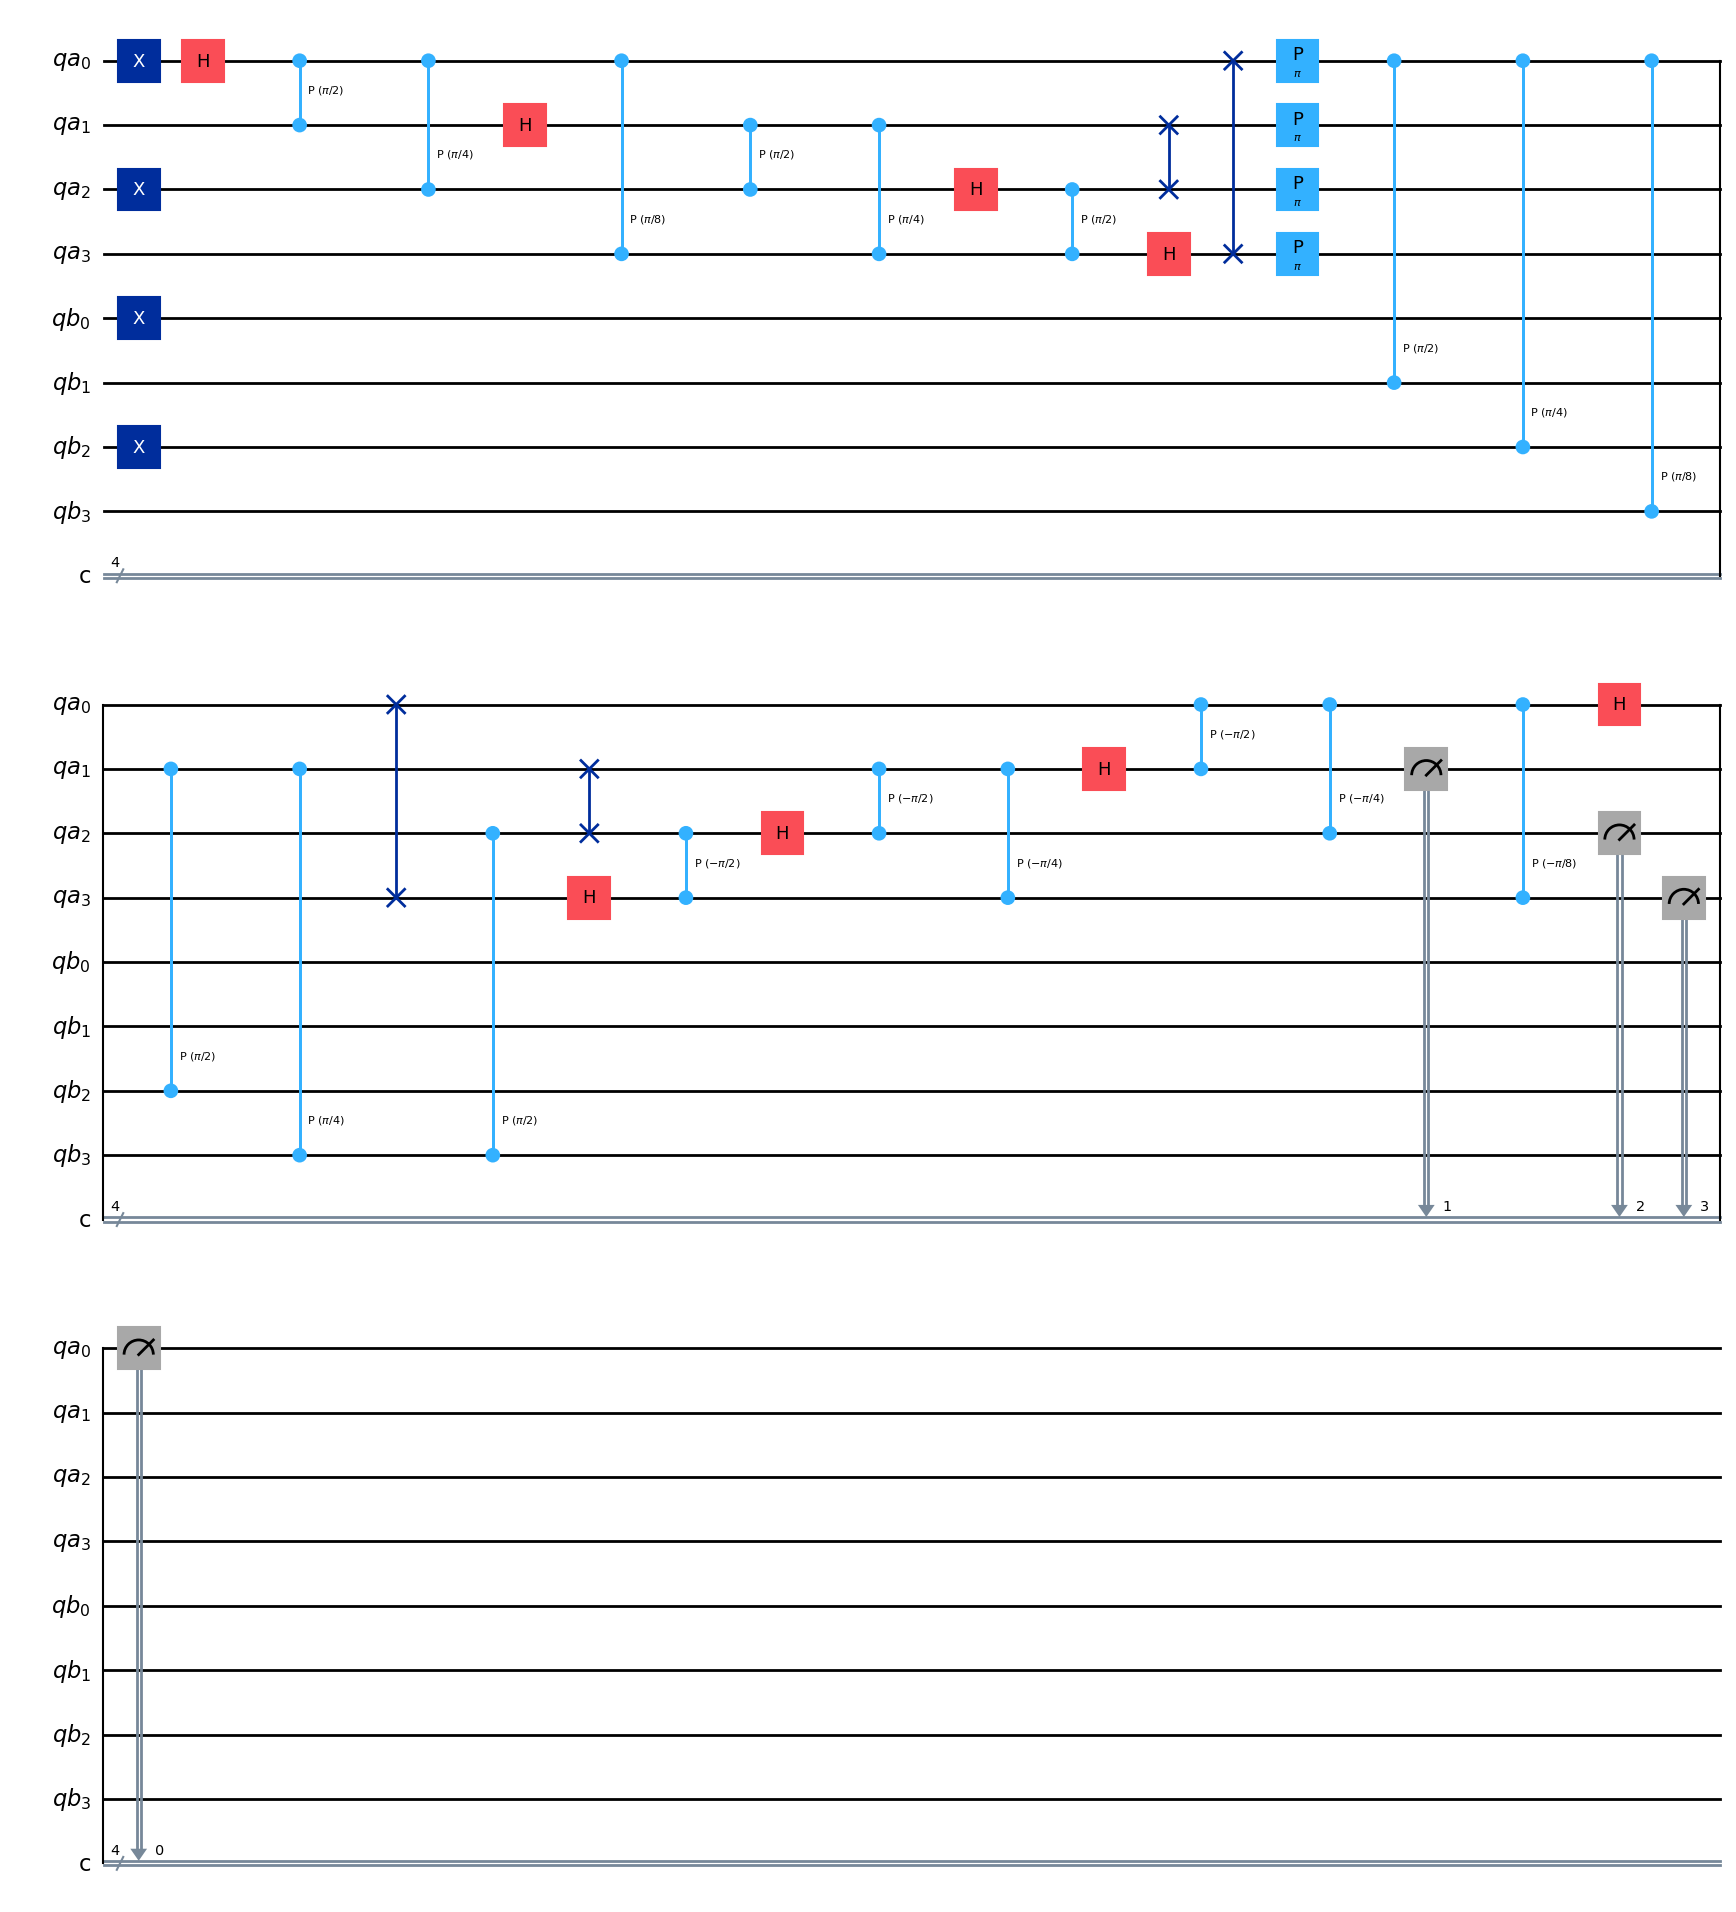

In [8]:
a = 5
b = 5
circuit = quantum_sum(a, b)
circuit.draw('mpl')

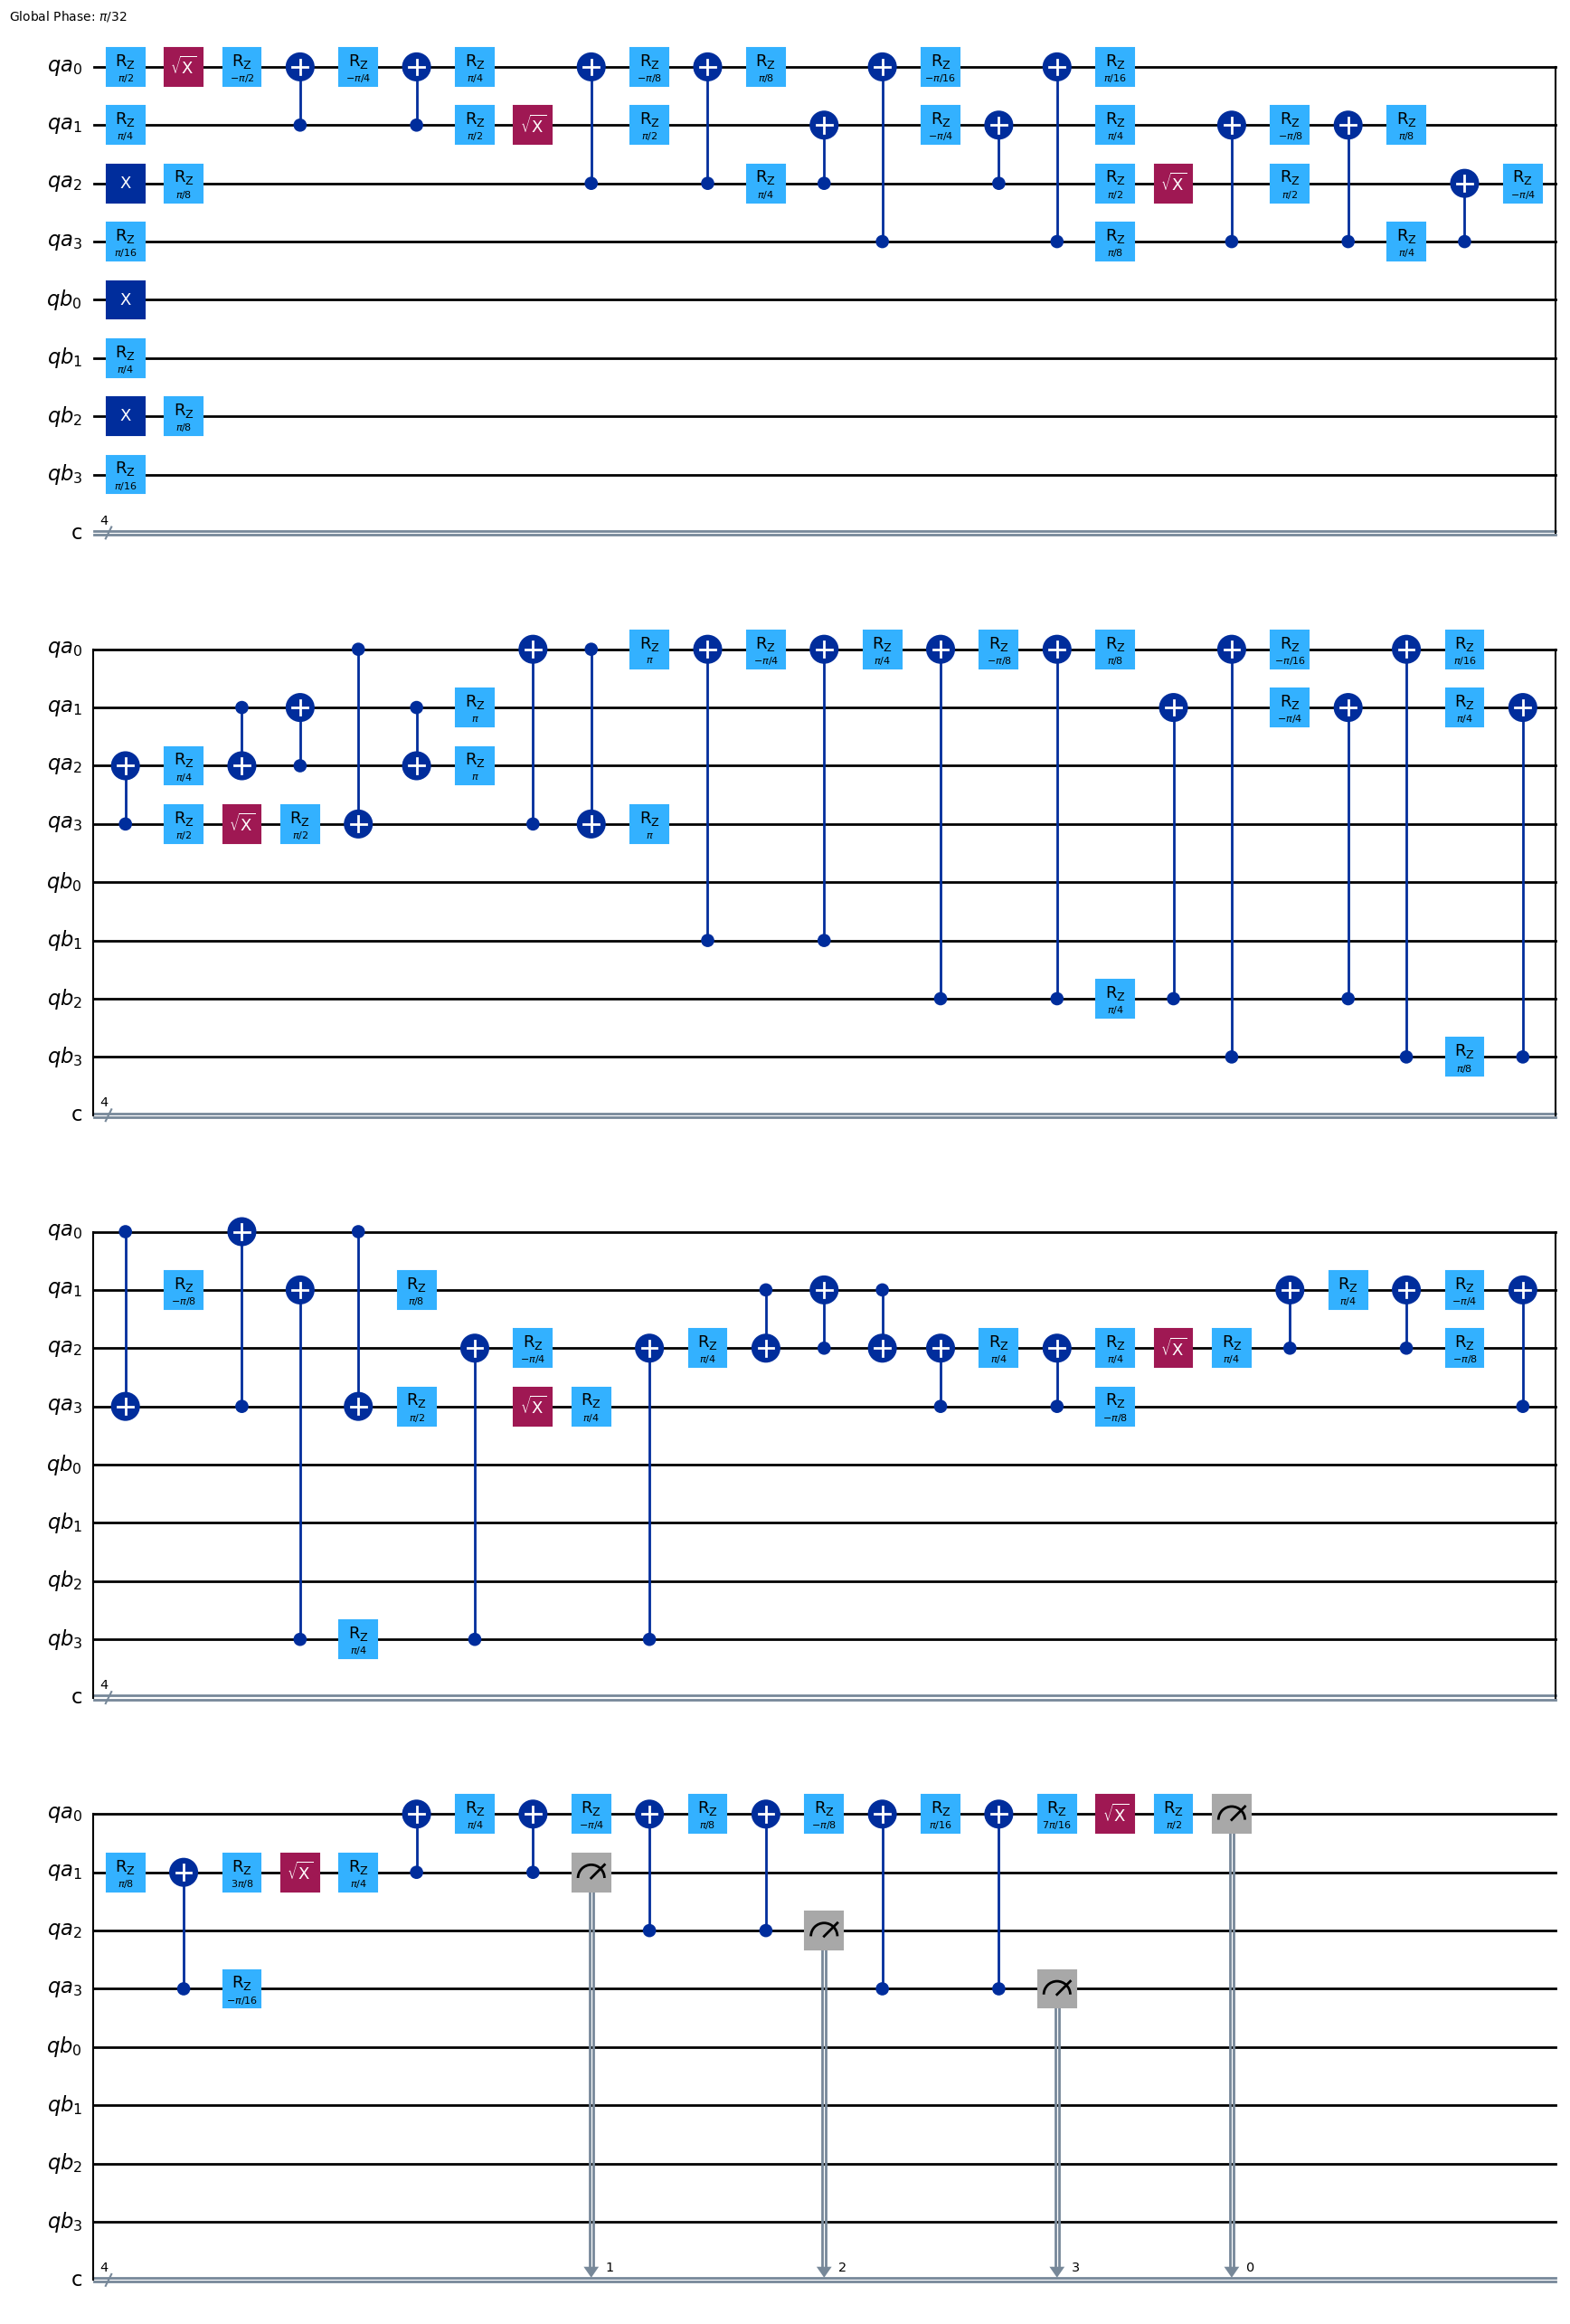

In [9]:
transpiled_circuit = transform_to_basis(circuit)
transpiled_circuit.draw('mpl')

### Simulation of the circuit without any noise

{'0001': 14, '1010': 1004, '0111': 78, '0011': 14, '1011': 468, '0110': 75, '1001': 16, '1000': 256, '0000': 58, '0010': 65}


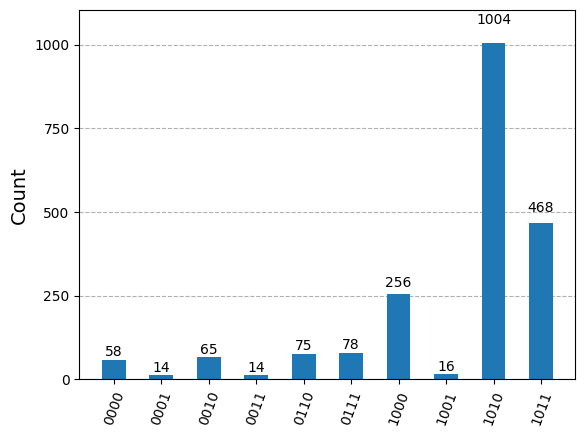

In [10]:
simulator = AerSimulator()
result = simulator.run(transpiled_circuit, shots=2048).result()
counts = result.get_counts(circuit)
print(counts)
plot_histogram(counts)

## Analyzing the effect of noise

In [22]:
def analyze_noise_effect(a, b, noise_levels, shots=2024):

  results = {}

  for alpha, beta in noise_levels:
    circuit = quantum_sum(a, b)
    transformed_circuit = transform_to_basis(circuit)
    noise_model = add_pauli_noise(alpha, beta, transformed_circuit)

    simulator = AerSimulator(noise_model=noise_model)

    result = simulator.run(transformed_circuit, shots=shots).result()
    counts = result.get_counts(transformed_circuit)
    results[(alpha, beta)] = counts

  return results

In [ ]:
noise_levels = [
  (0.01, 0.02),  # Low noise
  (0.05, 0.1),   # Medium noise
  (0.1, 0.2),    # High noise
]

a = 5
b = 5

results = analyze_noise_effect(a, b, noise_levels)

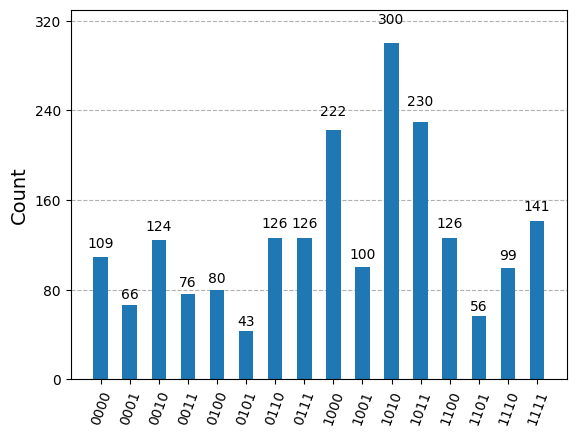

In [47]:
plot_histogram(dict(results.items())[(0.01, 0.02)])

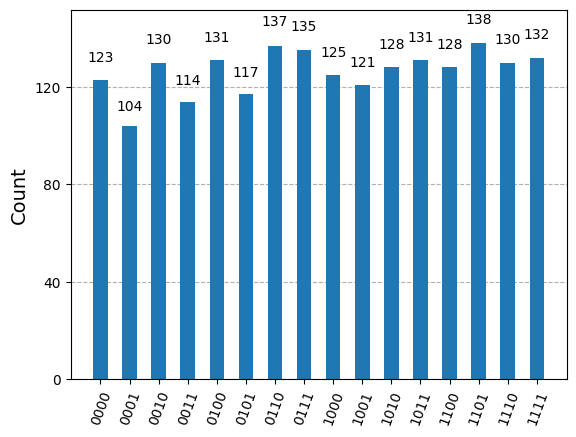

In [48]:
plot_histogram(dict(results.items())[(0.05, 0.1)])

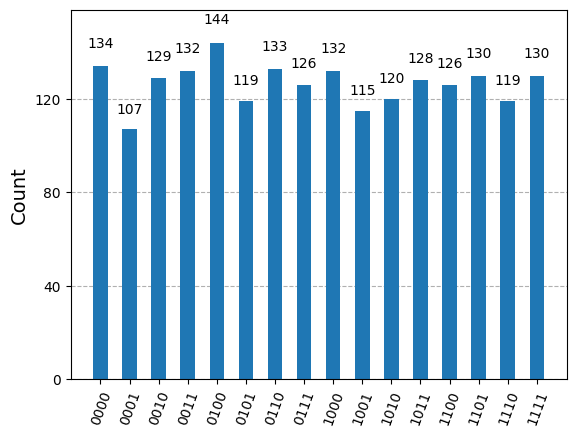

In [49]:
plot_histogram(dict(results.items())[(0.1, 0.2)])

## Analysis of Results

1. **Impact of Noise**:
   - Higher noise levels cause results to deviate from the expected sum, with errors spread across incorrect outputs due to random Pauli errors.

2. **Noise Mitigation**:
   - **Error Correction**: Adds qubits and complexity to reduce errors.
   - **Error Mitigation**: Techniques like zero-noise extrapolation reduce noise effects without full error correction.

3. **Effect of Gate Count**:
   - **Circuit Depth**: More gates increase exposure to noise.
   - **Optimization**: Reducing gate count and depth through circuit optimization can help maintain accuracy.